# Project: Switzerland Super League (2008-2016)

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

In this notebook I will investigate the **Switzerland Super League** from 2008 to 2016. The data comes from the [European Soccer Database](https://www.kaggle.com/hugomathien/soccer).

**Questions:**
<ul>
<li><a href="#Q1">1. Which are the best teams from Switzerland of every season?</a></li>
<li><a href="#Q2">2. What is the historical performance of the Swiss League teams (during the entire period)?</a></li>
</ul>

In [1]:
#Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

%matplotlib inline

<a id='wrangling'></a>
## Data Wrangling


### General Properties

In [2]:
# Load your data and print out a few lines. Perform operations to inspect data
#   types and look for instances of missing or possibly errant data.

# First we extract the data from the .sqlite database
con = sqlite3.connect("database.sqlite")

#Load data into Dataframes
country_df = pd.read_sql_query("SELECT * FROM Country", con)
league_df = pd.read_sql_query("SELECT * FROM League", con)
match_df = pd.read_sql_query("SELECT * FROM Match", con)
team_df = pd.read_sql_query("SELECT * FROM Team", con)

con.close()

In [3]:
# Now we will print first rows of every database.
#Countries database
country_df

,id,name
0,1,Belgium
1,1729,England
2,4769,France
3,7809,Germany
4,10257,Italy
5,13274,Netherlands
6,15722,Poland
7,17642,Portugal
8,19694,Scotland
9,21518,Spain


In [4]:
#Leagues database
league_df

,id,country_id,name
0,1,1,Belgium Jupiler League
1,1729,1729,England Premier League
2,4769,4769,France Ligue 1
3,7809,7809,Germany 1. Bundesliga
4,10257,10257,Italy Serie A
5,13274,13274,Netherlands Eredivisie
6,15722,15722,Poland Ekstraklasa
7,17642,17642,Portugal Liga ZON Sagres
8,19694,19694,Scotland Premier League
9,21518,21518,Spain LIGA BBVA


In [5]:
#First lines of Matches
match_df.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,4.00,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,3.80,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,...,2.50,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,...,7.50,1.45,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,...,1.73,4.50,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67


In [6]:
#First lines of teams
team_df.head()

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,1,9987,673.0,KRC Genk,GEN
1,2,9993,675.0,Beerschot AC,BAC
2,3,10000,15005.0,SV Zulte-Waregem,ZUL
3,4,9994,2007.0,Sporting Lokeren,LOK
4,5,9984,1750.0,KSV Cercle Brugge,CEB


#### Shape of selected dataframes (except countries and leagues that are small and are complete)

In [7]:
print("Matches dataframe has " + str(match_df.shape[0]) + " rows and " + str(match_df.shape[1]) +" columns")
print("Teams dataframe has " + str(team_df.shape[0]) + " rows and " + str(team_df.shape[1]) +" columns")

Matches dataframe has 25979 rows and 115 columns
Teams dataframe has 299 rows and 5 columns


#### Check duplicates

In [8]:
print(sum(match_df.duplicated()))
print(sum(team_df.duplicated()))

0
0


Seems we don't have duplicate row in our datasets

#### Check null values

In [9]:
print(match_df.isnull().sum().any())
print(team_df.isnull().sum().any())

True
True


We will have to check which variables have null values

#### Dataframes info

In [10]:
match_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25979 entries, 0 to 25978
Columns: 115 entries, id to BSA
dtypes: float64(96), int64(9), object(10)
memory usage: 22.8+ MB


In [11]:
team_df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 5 columns):
id                  299 non-null int64
team_api_id         299 non-null int64
team_fifa_api_id    288 non-null float64
team_long_name      299 non-null object
team_short_name     299 non-null object
dtypes: float64(1), int64(2), object(2)
memory usage: 11.8+ KB


With `.info()` method we have seen that **team_df** contains null values only in team_fifa_api_id column

### Data Cleaning

Now that we have overviewed our data, we will have to:

1. Join databases so we have id and know to what leagues and clubs correspond. 
2. Filter databases to only keep Swiss League matches and clubs
3. Keep only relevant columns

In [12]:
# First we will join countries and leagues.
countries_leagues = country_df.merge(league_df, how="left", on="id")
countries_leagues = countries_leagues.rename(columns={"name_x":"country_name","name_y":"league_name"})
countries_leagues

,id,country_name,country_id,league_name
0,1,Belgium,1,Belgium Jupiler League
1,1729,England,1729,England Premier League
2,4769,France,4769,France Ligue 1
3,7809,Germany,7809,Germany 1. Bundesliga
4,10257,Italy,10257,Italy Serie A
5,13274,Netherlands,13274,Netherlands Eredivisie
6,15722,Poland,15722,Poland Ekstraklasa
7,17642,Portugal,17642,Portugal Liga ZON Sagres
8,19694,Scotland,19694,Scotland Premier League
9,21518,Spain,21518,Spain LIGA BBVA


We are only interested in **Switzerland Super League**. As you may see `id` and `country_id` are the same! Now we'll be able to join that data with matches and identify Swiss League matches.

In [13]:
#First we drop irrelevant data and keep only country_id and League Name (indiferent with Country Name)
countries_leagues = countries_leagues[["country_id","league_name"]]
#Merge with matches data
matches_dfv2 =countries_leagues.merge(match_df, how="left",left_on="country_id",right_on="country_id")
## Now we will do a subsetting, if it everything ok we should have now less values
swiss_matches = matches_dfv2[matches_dfv2["league_name"] == "Switzerland Super League"]

print("Now we have " +
      str(swiss_matches.shape[0]) + 
      " matches, and before we had "+ 
      (str(matches_dfv2.shape[0])) +
      ". If we assume we have all the league matches played in these 11 leagues during all the period, we could say that" +
      " Swiss Superleague Matches represent the " +
      str(round((swiss_matches.shape[0]/matches_dfv2.shape[0])*100,2))+
    " % of the Top 11 European Leagues Matches played between 2008 and 2016.")

Now we have 1422 matches, and before we had 25979. If we assume we have all the league matches played in these 11 leagues during all the period, we could say that Swiss Superleague Matches represent the 5.47 % of the Top 11 European Leagues Matches played between 2008 and 2016.


In [14]:
# I want to see all the column names. So I will set this pandas config options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
#Store colnames in a list and print the list
cols = swiss_matches.columns.tolist()
cols

['country_id',
 'league_name',
 'id',
 'league_id',
 'season',
 'stage',
 'date',
 'match_api_id',
 'home_team_api_id',
 'away_team_api_id',
 'home_team_goal',
 'away_team_goal',
 'home_player_X1',
 'home_player_X2',
 'home_player_X3',
 'home_player_X4',
 'home_player_X5',
 'home_player_X6',
 'home_player_X7',
 'home_player_X8',
 'home_player_X9',
 'home_player_X10',
 'home_player_X11',
 'away_player_X1',
 'away_player_X2',
 'away_player_X3',
 'away_player_X4',
 'away_player_X5',
 'away_player_X6',
 'away_player_X7',
 'away_player_X8',
 'away_player_X9',
 'away_player_X10',
 'away_player_X11',
 'home_player_Y1',
 'home_player_Y2',
 'home_player_Y3',
 'home_player_Y4',
 'home_player_Y5',
 'home_player_Y6',
 'home_player_Y7',
 'home_player_Y8',
 'home_player_Y9',
 'home_player_Y10',
 'home_player_Y11',
 'away_player_Y1',
 'away_player_Y2',
 'away_player_Y3',
 'away_player_Y4',
 'away_player_Y5',
 'away_player_Y6',
 'away_player_Y7',
 'away_player_Y8',
 'away_player_Y9',
 'away_player_Y10

#### Now we've seen the column names we will keep:
*League_name

*Id

*Season

*Stage

*Match Api Id

*Home_team_api_id

*Away_team_api_id

*Home_team_goal

*Away_team_goal

In [15]:
#Subset by col names, and call swiss_matches_short
swiss_matches_short = swiss_matches[["league_name","id","season","stage", 'match_api_id','home_team_api_id',
               'away_team_api_id','home_team_goal','away_team_goal']]
swiss_matches_short.head()

,league_name,id,season,stage,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal
24557,Switzerland Super League,24558,2008/2009,1,486262,9956,6493,3,1
24558,Switzerland Super League,24559,2008/2009,1,486263,10192,9931,1,2
24559,Switzerland Super League,24560,2008/2009,1,486264,9930,10179,3,1
24560,Switzerland Super League,24561,2008/2009,1,486265,10199,9824,1,2
24561,Switzerland Super League,24562,2008/2009,1,486266,7955,10243,1,2


We also want to know who are the home_team_api_id and away_team_api_id. We will have to get that data from `teams_df`

In [16]:
home_teams = swiss_matches_short['home_team_api_id'].unique()
away_teams = swiss_matches_short['away_team_api_id'].unique()

# Check if home teams and away teams are same, empty array means the values are same
np.setdiff1d(home_teams, away_teams)

array([], dtype=int64)

In [17]:
print("In short, we have " + str(home_teams.shape[0]) + " Swiss Super League Clubs!")

In short, we have 15 Swiss Super League Clubs!


In [18]:
print("Also, we have " + str(swiss_matches_short['season'].unique().shape[0]) + " seasons of Swiss League ")

Also, we have 8 seasons of Swiss League 


In [19]:
swiss_seasons = swiss_matches_short['season'].unique()

##### Now we now how many Swiss Clubs we have, who are those clubs?
This is important to know, because we are going to add those names to our swiss_matches_shor dataframe

In [20]:
#First convert home_teams array into a list
swiss_teams_id = list(home_teams)
#Filter teams_df by list
swiss_teams = team_df[team_df.team_api_id.isin(swiss_teams_id)].reset_index()
#Keep only relevant columns
swiss_teams = swiss_teams[["team_api_id","team_long_name","team_short_name"]]
# Print 
swiss_teams

,team_api_id,team_long_name,team_short_name
0,9956,Grasshopper Club Zürich,GRA
1,6493,AC Bellinzona,BEL
2,10192,BSC Young Boys,YB
3,9931,FC Basel,BAS
4,9930,FC Aarau,AAR
5,10179,FC Sion,SIO
6,10199,FC Luzern,LUZ
7,9824,FC Vaduz,VAD
8,7955,Neuchâtel Xamax,XAM
9,10243,FC Zürich,ZUR


Now we have those teams we will include them in the `swiss_matches_short` dataframe

In [21]:
#First we add the home_team name
naming_v1 = swiss_matches_short.merge(swiss_teams, how="left",left_on="home_team_api_id",right_on="team_api_id")
naming_v1 = naming_v1.rename(columns={"team_long_name":"home_team"})
naming_v1 = naming_v1.drop(columns=["team_short_name","team_api_id"])
#Then we add the away_team name
naming_v2 = naming_v1.merge(swiss_teams, how="left",left_on="away_team_api_id",right_on="team_api_id")
naming_v2 = naming_v2.rename(columns={"team_long_name":"away_team"})
naming_v2 = naming_v2.drop(columns=["team_api_id", "team_short_name"])

In [22]:
#Set the order of columns we want to use
order_of_columns = ['league_name', 'id', 'season', 'stage', 'match_api_id',
       'home_team', 'away_team', 'home_team_goal',
       'away_team_goal']

In [23]:
#Now we have our swiss_matches database cleaned, we will rename it and save it for our EDA
swiss_matches_df = naming_v2[order_of_columns]
#For example now we know Grasshopper Club Zurich won 3-1 to AC Bellinzona on 2008/2009 season!
swiss_matches_df.head()

,league_name,id,season,stage,match_api_id,home_team,away_team,home_team_goal,away_team_goal
0,Switzerland Super League,24558,2008/2009,1,486262,Grasshopper Club Zürich,AC Bellinzona,3,1
1,Switzerland Super League,24559,2008/2009,1,486263,BSC Young Boys,FC Basel,1,2
2,Switzerland Super League,24560,2008/2009,1,486264,FC Aarau,FC Sion,3,1
3,Switzerland Super League,24561,2008/2009,1,486265,FC Luzern,FC Vaduz,1,2
4,Switzerland Super League,24562,2008/2009,1,486266,Neuchâtel Xamax,FC Zürich,1,2


<a id='eda'></a>
## Exploratory Data Analysis

<a id='Q1'></a>

### Research Question 1. Which are the best teams from Switzerland of every season?

If we want to know that, we will have to create a standings table for every season and the make a few viz

In [24]:
#This function builds a season table
def construct_table(master, teams, season):
    cur_master = master[(master['season'] == season)]
    cur_teams = cur_master['home_team'].unique()
    #cur_teams = teams[teams['team_api_id'].isin(cur_teams)]
    cols = ['Played', 'Won', 'Drawn', 'Lost', 'GF', 'GA']
    table = teams[teams['team_long_name'].isin(cur_teams)].copy()
    for i in cols:
        table[i] = 0
    for i in cur_master.index:
        cur = cur_master.loc[i]
        home_team = table['team_long_name'] == cur['home_team']
        away_team = table['team_long_name'] == cur['away_team']
        
        table.loc[home_team, 'Played'] += 1
        table.loc[away_team, 'Played'] += 1
        
        home_goals = cur['home_team_goal']
        away_goals = cur['away_team_goal']
        
        table.loc[home_team, 'GF'] += home_goals
        table.loc[home_team, 'GA'] += away_goals
        table.loc[away_team, 'GF'] += away_goals
        table.loc[away_team, 'GA'] += home_goals
        
        if home_goals == away_goals:
            table.loc[home_team, 'Drawn'] += 1
            table.loc[away_team, 'Drawn'] += 1
        elif home_goals > away_goals:
            table.loc[home_team, 'Won'] += 1
            table.loc[away_team, 'Lost'] += 1
        else:
            table.loc[home_team, 'Lost'] += 1
            table.loc[away_team, 'Won'] += 1
        
        table['GD'] = table['GF'] - table['GA']
        table['Points'] = 3 * table['Won'] + table['Drawn']
        table.sort_values(['Points', 'GD', 'GF', 'GA'], ascending=False, inplace=True)
        table.index = range(1,len(table) + 1)
        
    return table

In [25]:
swiss_seasons

array(['2008/2009', '2009/2010', '2010/2011', '2011/2012', '2012/2013',
       '2013/2014', '2014/2015', '2015/2016'], dtype=object)

In [26]:
# Build a table for each season
season09_ssl_standings = construct_table(swiss_matches_df, swiss_teams, swiss_seasons[0])
season10_ssl_standings = construct_table(swiss_matches_df, swiss_teams, swiss_seasons[1])
season11_ssl_standings = construct_table(swiss_matches_df, swiss_teams, swiss_seasons[2])
season12_ssl_standings = construct_table(swiss_matches_df, swiss_teams, swiss_seasons[3])
season13_ssl_standings = construct_table(swiss_matches_df, swiss_teams, swiss_seasons[4])
season14_ssl_standings = construct_table(swiss_matches_df, swiss_teams, swiss_seasons[5])
season15_ssl_standings = construct_table(swiss_matches_df, swiss_teams, swiss_seasons[6])
season16_ssl_standings = construct_table(swiss_matches_df, swiss_teams, swiss_seasons[7])
#Create a variable for each season
season09_ssl_standings['season'] = swiss_seasons[0]
season10_ssl_standings['season'] = swiss_seasons[1]
season11_ssl_standings['season'] = swiss_seasons[2]
season12_ssl_standings['season'] = swiss_seasons[3]
season13_ssl_standings['season'] = swiss_seasons[4]
season14_ssl_standings['season'] = swiss_seasons[5]
season15_ssl_standings['season'] = swiss_seasons[6]
season16_ssl_standings['season'] = swiss_seasons[7]

### Now we will explore the winners of every season

In [27]:
season09_ssl_standings

,team_api_id,team_long_name,team_short_name,Played,Won,Drawn,Lost,GF,GA,GD,Points,season
1,10243,FC Zürich,ZUR,36,24,7,5,80,36,44,79,2008/2009
2,10192,BSC Young Boys,YB,36,22,7,7,85,46,39,73,2008/2009
3,9931,FC Basel,BAS,36,22,6,8,72,44,28,72,2008/2009
4,9956,Grasshopper Club Zürich,GRA,36,12,14,10,57,48,9,50,2008/2009
5,9930,FC Aarau,AAR,36,11,11,14,35,51,-16,44,2008/2009
6,6493,AC Bellinzona,BEL,36,11,10,15,44,51,-7,43,2008/2009
7,7955,Neuchâtel Xamax,XAM,36,10,10,16,50,57,-7,40,2008/2009
8,10179,FC Sion,SIO,36,9,10,17,44,60,-16,37,2008/2009
9,10199,FC Luzern,LUZ,36,9,8,19,45,62,-17,35,2008/2009
10,9824,FC Vaduz,VAD,36,5,7,24,28,85,-57,22,2008/2009


In [28]:
season10_ssl_standings

,team_api_id,team_long_name,team_short_name,Played,Won,Drawn,Lost,GF,GA,GD,Points,season
1,9931,FC Basel,BAS,36,25,5,6,90,46,44,80,2009/2010
2,10192,BSC Young Boys,YB,36,25,2,9,78,47,31,77,2009/2010
3,9956,Grasshopper Club Zürich,GRA,36,21,2,13,65,43,22,65,2009/2010
4,10199,FC Luzern,LUZ,36,17,7,12,66,55,11,58,2009/2010
5,10179,FC Sion,SIO,36,14,9,13,63,57,6,51,2009/2010
6,10190,FC St. Gallen,GAL,36,13,7,16,53,56,-3,46,2009/2010
7,10243,FC Zürich,ZUR,36,12,9,15,55,58,-3,45,2009/2010
8,7955,Neuchâtel Xamax,XAM,36,11,8,17,55,57,-2,41,2009/2010
9,6493,AC Bellinzona,BEL,36,7,4,25,42,92,-50,25,2009/2010
10,9930,FC Aarau,AAR,36,6,5,25,32,88,-56,23,2009/2010


In [29]:
season11_ssl_standings

,team_api_id,team_long_name,team_short_name,Played,Won,Drawn,Lost,GF,GA,GD,Points,season
1,9931,FC Basel,BAS,36,21,10,5,76,44,32,73,2010/2011
2,10243,FC Zürich,ZUR,36,21,9,6,74,44,30,72,2010/2011
3,10192,BSC Young Boys,YB,36,15,12,9,65,50,15,57,2010/2011
4,10179,FC Sion,SIO,36,15,9,12,47,36,11,54,2010/2011
5,10191,FC Thun,THU,36,11,16,9,48,43,5,49,2010/2011
6,10199,FC Luzern,LUZ,36,13,9,14,62,57,5,48,2010/2011
7,9956,Grasshopper Club Zürich,GRA,36,10,11,15,45,54,-9,41,2010/2011
8,7955,Neuchâtel Xamax,XAM,36,8,8,20,44,67,-23,32,2010/2011
9,6493,AC Bellinzona,BEL,36,7,11,18,42,75,-33,32,2010/2011
10,10190,FC St. Gallen,GAL,36,8,7,21,34,67,-33,31,2010/2011


In [30]:
season12_ssl_standings

,team_api_id,team_long_name,team_short_name,Played,Won,Drawn,Lost,GF,GA,GD,Points,season
1,9931,FC Basel,BAS,34,22,8,4,78,33,45,74,2011/2012
2,10199,FC Luzern,LUZ,34,14,12,8,46,32,14,54,2011/2012
3,10179,FC Sion,SIO,34,15,8,11,40,35,5,53,2011/2012
4,10192,BSC Young Boys,YB,34,13,12,9,52,38,14,51,2011/2012
5,9777,Servette FC,SER,34,14,6,14,45,53,-8,48,2011/2012
6,10191,FC Thun,THU,34,11,10,13,38,41,-3,43,2011/2012
7,10243,FC Zürich,ZUR,34,11,8,15,43,44,-1,41,2011/2012
8,7730,FC Lausanne-Sports,LAU,34,8,6,20,29,61,-32,30,2011/2012
9,7955,Neuchâtel Xamax,XAM,18,7,5,6,22,22,0,26,2011/2012
10,9956,Grasshopper Club Zürich,GRA,34,7,5,22,32,66,-34,26,2011/2012


In [31]:
season13_ssl_standings

,team_api_id,team_long_name,team_short_name,Played,Won,Drawn,Lost,GF,GA,GD,Points,season
1,9931,FC Basel,BAS,36,21,9,6,61,31,30,72,2012/2013
2,9956,Grasshopper Club Zürich,GRA,36,20,9,7,48,32,16,69,2012/2013
3,10190,FC St. Gallen,GAL,36,17,8,11,54,36,18,59,2012/2013
4,10243,FC Zürich,ZUR,36,16,7,13,62,48,14,55,2012/2013
5,10191,FC Thun,THU,36,13,9,14,44,46,-2,48,2012/2013
6,10179,FC Sion,SIO,36,13,9,14,40,54,-14,48,2012/2013
7,10192,BSC Young Boys,YB,36,11,10,15,48,50,-2,43,2012/2013
8,10199,FC Luzern,LUZ,36,10,12,14,41,52,-11,42,2012/2013
9,7730,FC Lausanne-Sports,LAU,36,8,9,19,32,51,-19,33,2012/2013
10,9777,Servette FC,SER,36,6,8,22,32,62,-30,26,2012/2013


In [32]:
season14_ssl_standings

,team_api_id,team_long_name,team_short_name,Played,Won,Drawn,Lost,GF,GA,GD,Points,season
1,9931,FC Basel,BAS,36,19,15,2,70,34,36,72,2013/2014
2,9956,Grasshopper Club Zürich,GRA,36,19,8,9,67,43,24,65,2013/2014
3,10192,BSC Young Boys,YB,36,17,8,11,59,50,9,59,2013/2014
4,10199,FC Luzern,LUZ,36,15,6,15,48,54,-6,51,2013/2014
5,10243,FC Zürich,ZUR,36,14,8,14,51,52,-1,50,2013/2014
6,10191,FC Thun,THU,36,13,9,14,57,53,4,48,2013/2014
7,10190,FC St. Gallen,GAL,36,11,12,13,37,47,-10,45,2013/2014
8,10179,FC Sion,SIO,36,12,7,17,38,45,-7,43,2013/2014
9,9930,FC Aarau,AAR,36,12,6,18,55,71,-16,42,2013/2014
10,7730,FC Lausanne-Sports,LAU,36,7,3,26,38,71,-33,24,2013/2014


In [33]:
season15_ssl_standings

,team_api_id,team_long_name,team_short_name,Played,Won,Drawn,Lost,GF,GA,GD,Points,season
1,9931,FC Basel,BAS,36,24,6,6,84,41,43,78,2014/2015
2,10192,BSC Young Boys,YB,36,19,9,8,64,45,19,66,2014/2015
3,10243,FC Zürich,ZUR,36,15,8,13,55,48,7,53,2014/2015
4,10191,FC Thun,THU,36,13,13,10,47,45,2,52,2014/2015
5,10199,FC Luzern,LUZ,36,12,11,13,54,46,8,47,2014/2015
6,10190,FC St. Gallen,GAL,36,13,8,15,57,65,-8,47,2014/2015
7,10179,FC Sion,SIO,36,12,9,15,47,48,-1,45,2014/2015
8,9956,Grasshopper Club Zürich,GRA,36,11,10,15,50,56,-6,43,2014/2015
9,9824,FC Vaduz,VAD,36,7,10,19,28,59,-31,31,2014/2015
10,9930,FC Aarau,AAR,36,6,12,18,31,64,-33,30,2014/2015


In [34]:
season16_ssl_standings

,team_api_id,team_long_name,team_short_name,Played,Won,Drawn,Lost,GF,GA,GD,Points,season
1,9931,FC Basel,BAS,36,26,5,5,88,38,50,83,2015/2016
2,10192,BSC Young Boys,YB,36,20,9,7,78,47,31,69,2015/2016
3,10199,FC Luzern,LUZ,36,15,9,12,59,50,9,54,2015/2016
4,9956,Grasshopper Club Zürich,GRA,36,15,8,13,65,56,9,53,2015/2016
5,10179,FC Sion,SIO,36,14,8,14,52,49,3,50,2015/2016
6,10191,FC Thun,THU,36,10,11,15,45,54,-9,41,2015/2016
7,10190,FC St. Gallen,GAL,36,10,8,18,41,66,-25,38,2015/2016
8,9824,FC Vaduz,VAD,36,7,15,14,44,60,-16,36,2015/2016
9,7896,Lugano,LUG,36,9,8,19,46,75,-29,35,2015/2016
10,10243,FC Zürich,ZUR,36,7,13,16,48,71,-23,34,2015/2016


**Top 3 Teams by Season**

**Season 2008/09**
- Champion: FC Zurich
- Runner Up: BSC Young Boys
- Relegation: FC Vaduz

**Season 2009/10**
- Champion: FC Basel
- Runner Up: BSC Young Boys
- Relegation: FC Aarau

**Season 2010/11**
- Champion: FC Basel
- Runner Up: FC Zurich
- Relegation: FC St. Gallen

**Season 2011/12**
- Champion: FC Basel
- Runner Up: FC Luzern
- Relegation: Neuchâtel Xamax (Grasshopper got last, but Neuchatel got relegated)

**Season 2012/13**
- Champion: FC Basel
- Runner Up: Grasshopper Club Zürich
- Relegation: Servette FC

**Season 2013/14**
- Champion: FC Basel
- Runner Up: Grasshopper Club Zürich
- Relegation: FC Lausanne-Sports

**Season 2014/15**
- Champion: FC Basel
- Runner Up: BSC Young Boys
- Relegation: FC Aarau

**Season 2015/16**
- Champion: FC Basel
- Runner Up: BSC Young Boys
- Relegation: FC Zurich

#### 1 Title (2008/09) and 1 relegation for FC Zurich (2015/16)

<img src="fczurich.png" />

#### 7 titles for FC Basel, by far the best team of the period


<img src="Logo_FC_Basel..png" style="width:400px;height:400px"/> 

#### We can also explore the matches played by season

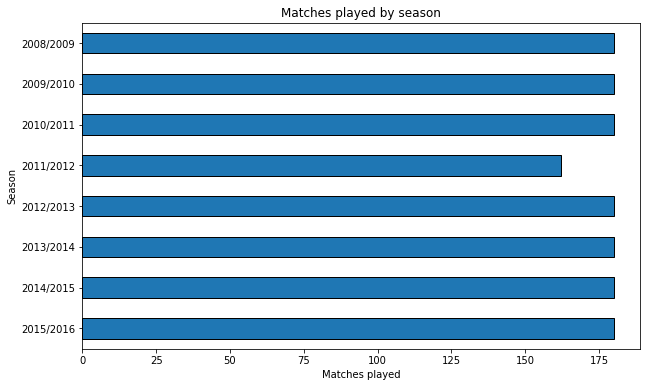

In [35]:
swiss_matches_df.groupby("season").count()["league_name"].sort_index(ascending=False).plot(kind="barh",figsize = (10,6),
                                                                                 edgecolor = "k",
                                                                                 linewidth =1)
plt.title("Matches played by season")
plt.ylabel("Season")
plt.xlabel("Matches played")
plt.show()

We see that 2011/2012 has less matches played than other seasons. I've googled what happend. A team called Neuchâtel Xamax was expelled midway through the season over severe financial irregularities. It only played 18 of 34 matches.
You can continue [here](https://www.deseret.com/2012/1/18/20245369/neuchatel-xamax-loses-swiss-league-license) if you want to keep reading about it.


We can also see home and away goals by season, 2009/2010 home teams scored a lot of goals!

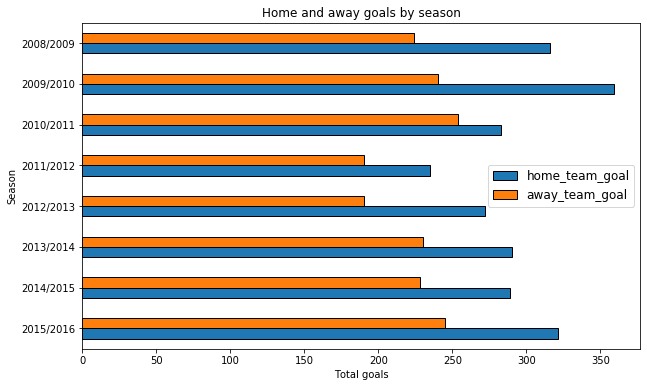

In [36]:
swiss_matches_df.groupby("season").agg({"home_team_goal":"sum","away_team_goal":"sum"}).sort_index(ascending=False).plot(kind="barh",
                                                                                 figsize = (10,6),
                                                                                 edgecolor = "k",
                                                                                 linewidth =1)
plt.title("Home and away goals by season")
plt.legend(prop = {"size" : 12})
plt.ylabel("Season")
plt.xlabel("Total goals")
plt.show()

In [37]:
# We have concatenated our seasons. Now we will build a lineplot that includes all teams and ending position by season
concated_seasons = pd.concat([season09_ssl_standings, 
                        season10_ssl_standings,
                        season11_ssl_standings,
                        season12_ssl_standings,
                        season13_ssl_standings,
                        season14_ssl_standings,
                        season15_ssl_standings,
                        season16_ssl_standings])

concated_seasons["position"] = concated_seasons.index
concated_seasons = concated_seasons[["team_long_name","season","position"]]

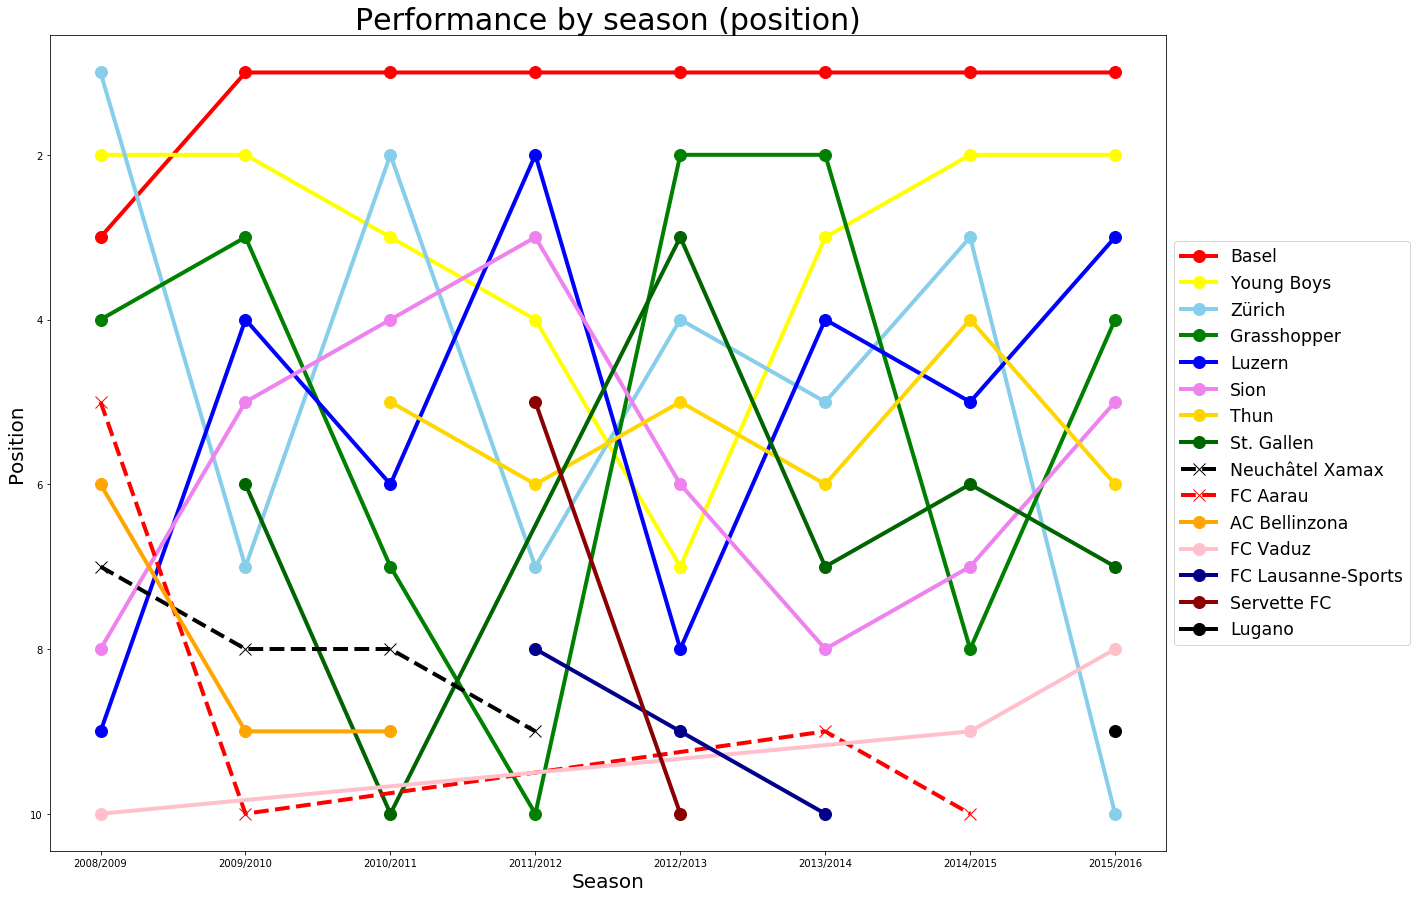

In [38]:
#Do one for each team
basel = concated_seasons[concated_seasons["team_long_name"] == "FC Basel"]
young_boys = concated_seasons[concated_seasons["team_long_name"] == "BSC Young Boys"]
zurich = concated_seasons[concated_seasons["team_long_name"] == "FC Zürich"]
grasshopper = concated_seasons[concated_seasons["team_long_name"] == "Grasshopper Club Zürich"]
luzern = concated_seasons[concated_seasons["team_long_name"] == "FC Luzern"]
sion = concated_seasons[concated_seasons["team_long_name"] == "FC Sion"]
thun = concated_seasons[concated_seasons["team_long_name"] == "FC Thun"]
st_gallen = concated_seasons[concated_seasons["team_long_name"] == "FC St. Gallen"]
neuch = concated_seasons[concated_seasons["team_long_name"] == "Neuchâtel Xamax"]
arau = concated_seasons[concated_seasons["team_long_name"] == "FC Aarau"]
bellinzona = concated_seasons[concated_seasons["team_long_name"] == "AC Bellinzona"]
vaduz = concated_seasons[concated_seasons["team_long_name"] == "FC Vaduz"]
laussanne = concated_seasons[concated_seasons["team_long_name"] == "FC Lausanne-Sports"]
servette = concated_seasons[concated_seasons["team_long_name"] == "Servette FC"]
lugano = concated_seasons[concated_seasons["team_long_name"] == "Lugano"]

#Use matplotlib
plt.figure(figsize=(20,15)) 
plt.plot( 'season', 'position', data=basel, marker='o', markersize=12, color='red', linewidth=4, label="Basel")
plt.plot( 'season', 'position', data=young_boys, marker='o', markersize=12, color='yellow', linewidth=4, label="Young Boys")
plt.plot( 'season', 'position', data=zurich, marker='o', markersize=12, color='skyblue', linewidth=4, label="Zürich")
plt.plot( 'season', 'position', data=grasshopper, marker='o', markersize=12, color='green', linewidth=4, label="Grasshopper")
plt.plot( 'season', 'position', data=luzern, marker='o', markersize=12, color='blue', linewidth=4, label="Luzern")
plt.plot( 'season', 'position', data=sion, marker='o', markersize=12, color='violet', linewidth=4, label="Sion")
plt.plot( 'season', 'position', data=thun, marker='o', markersize=12, color='gold', linewidth=4, label="Thun")
plt.plot( 'season', 'position', data=st_gallen, marker='o', markersize=12, color='darkgreen', linewidth=4, label="St. Gallen")
plt.plot( 'season', 'position', data=neuch, marker='x', markersize=12, color='black', linewidth=4,linestyle='dashed', label="Neuchâtel Xamax")
plt.plot( 'season', 'position', data=arau, marker='x', markersize=12, color='red', linewidth=4,linestyle='dashed', label= "FC Aarau")
plt.plot( 'season', 'position', data=bellinzona, marker='o', markersize=12, color='orange', linewidth=4, label="AC Bellinzona")
plt.plot( 'season', 'position', data=vaduz, marker='o', markersize=12, color='pink', linewidth=4, label="FC Vaduz")
plt.plot( 'season', 'position', data=laussanne, marker='o', markersize=12, color='darkblue', linewidth=4, label="FC Lausanne-Sports")
plt.plot( 'season', 'position', data=servette, marker='o', markersize=12, color='darkred', linewidth=4, label="Servette FC")
plt.plot( 'season', 'position', data=lugano, marker='o', markersize=12, color='black', linewidth=4, label="Lugano")
plt.gca().invert_yaxis()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize='xx-large')
plt.title("Performance by season (position)",fontsize=30)
plt.xlabel("Season",fontsize=20)
plt.ylabel("Position",fontsize=20)
plt.show()

<a id='Q2'></a>

### Research Question 2. What is the historical performance of the Swiss League teams (during the entire period)?

In [39]:
# First we will build a table for every season
season09_table = construct_table(swiss_matches_df, swiss_teams, swiss_seasons[0])
season10_table = construct_table(swiss_matches_df, swiss_teams, swiss_seasons[1])
season11_table = construct_table(swiss_matches_df, swiss_teams, swiss_seasons[2])
season12_table = construct_table(swiss_matches_df, swiss_teams, swiss_seasons[3])
season13_table = construct_table(swiss_matches_df, swiss_teams, swiss_seasons[4])
season14_table = construct_table(swiss_matches_df, swiss_teams, swiss_seasons[5])
season15_table = construct_table(swiss_matches_df, swiss_teams, swiss_seasons[6])
season16_table = construct_table(swiss_matches_df, swiss_teams, swiss_seasons[7])
#Concat every season for building a Historical Season Table
long_table = pd.concat([season09_table, season10_table,season11_table,season12_table,season13_table,season14_table,season15_table,season16_table])
#Check table
long_table.head(3)

,team_api_id,team_long_name,team_short_name,Played,Won,Drawn,Lost,GF,GA,GD,Points
1,10243,FC Zürich,ZUR,36,24,7,5,80,36,44,79
2,10192,BSC Young Boys,YB,36,22,7,7,85,46,39,73
3,9931,FC Basel,BAS,36,22,6,8,72,44,28,72


In [40]:
#With that we will build the historical standings table of the Swiss Super League
historical_standings = long_table.groupby(['team_api_id','team_long_name','team_short_name']).sum().sort_values('Points', ascending=False)
# Print table
historical_standings

,,,Played,Won,Drawn,Lost,GF,GA,GD,Points
team_api_id,team_long_name,team_short_name,,,,,,,,
9931,FC Basel,BAS,286,180,64,42,619,311,308,604
10192,BSC Young Boys,YB,286,142,69,75,529,373,156,495
10243,FC Zürich,ZUR,286,120,69,97,468,401,67,429
9956,Grasshopper Club Zürich,GRA,286,115,67,104,429,398,31,412
10199,FC Luzern,LUZ,286,105,74,107,421,408,13,389
10179,FC Sion,SIO,286,104,69,113,371,384,-13,381
10191,FC Thun,THU,214,71,68,75,279,282,-3,281
10190,FC St. Gallen,GAL,216,72,50,94,276,337,-61,266
7955,Neuchâtel Xamax,XAM,126,36,31,59,171,203,-32,139


* As we can see FC Basel, BSC Young Boys, FC Zurich, Grasshopper Club Zurich, FC Luzern and FC Sion are the only teams that never were relegated during the 2008-2016 period

* FC Basel is by long the team with the best performance. The second best is Young Boys and its 109 points away from FC Basel performance, thats 36 wins and 1 tie in terms of points (a lot)!!. Also, FC Basel has the best Goal Difference (308 on favor goals) and scored more goals than the rest. Comparing with the teams that played all the seasons, FC Basel has the best defense (less recieved goals) and attack

* In spite of the fact that BSC Young Boys didn't earned a title during this period, has a better historical performance that FC Zurich that won the league in 2008/09 season

#### Stacked barplot of performance by teams

In [41]:
#Create a DF with vars I only inteset
stacked_base = long_table[["team_long_name",
            "Played", 
            "Won",
            "Drawn",
            "Lost",               
            "Points"]].groupby("team_long_name").sum().sort_values('Points', ascending=False)

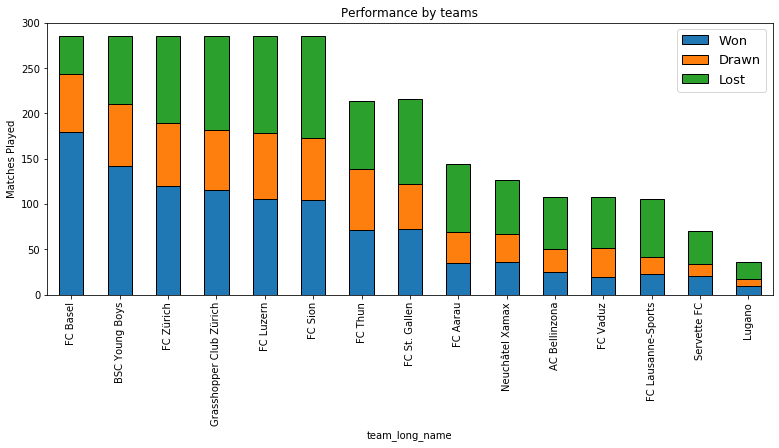

In [42]:
#Stacked barplot of performance
stacked_base[["Won","Drawn","Lost"]].plot(kind = "bar",figsize=(13,5),
                                   stacked =True,linewidth = 1,
                                   edgecolor = "k"*20
                                  )
plt.legend(loc="best",prop = {"size" : 13})
plt.title("Performance by teams")
plt.ylabel("Matches Played")
plt.show()

#### We can also see the wins ratio


In [43]:
historical_standings["Won"] / historical_standings["Played"] 

team_api_id  team_long_name           team_short_name
9931         FC Basel                 BAS                0.629371
10192        BSC Young Boys           YB                 0.496503
10243        FC Zürich                ZUR                0.419580
9956         Grasshopper Club Zürich  GRA                0.402098
10199        FC Luzern                LUZ                0.367133
10179        FC Sion                  SIO                0.363636
10191        FC Thun                  THU                0.331776
10190        FC St. Gallen            GAL                0.333333
7955         Neuchâtel Xamax          XAM                0.285714
9930         FC Aarau                 AAR                0.243056
6493         AC Bellinzona            BEL                0.231481
9824         FC Vaduz                 VAD                0.175926
7730         FC Lausanne-Sports       LAU                0.216981
9777         Servette FC              SER                0.285714
7896         Lugano   

* Of every 10 league games played, FC Basel won 6. It has the biggest wins ratio. FC Thun is has the lowest, only a 17% victory ratio.


#### What the scored goals and recieved goals ratio

In [44]:
goals = pd.DataFrame()
# Goalds team scored per match (Average)
goals["scored_goals_ratio"] = historical_standings["GF"] / historical_standings["Played"] 
# Goals rivals scored per match (Average)
goals["recieved_goals_ratio"] = historical_standings["GA"] / historical_standings["Played"]
#Se the Df
goals

,,,scored_goals_ratio,recieved_goals_ratio
team_api_id,team_long_name,team_short_name,,
9931,FC Basel,BAS,2.164336,1.087413
10192,BSC Young Boys,YB,1.849650,1.304196
10243,FC Zürich,ZUR,1.636364,1.402098
9956,Grasshopper Club Zürich,GRA,1.500000,1.391608
10199,FC Luzern,LUZ,1.472028,1.426573
10179,FC Sion,SIO,1.297203,1.342657
10191,FC Thun,THU,1.303738,1.317757
10190,FC St. Gallen,GAL,1.277778,1.560185
7955,Neuchâtel Xamax,XAM,1.357143,1.611111


* FC Basel scored on average 2.16 goals per match, and rivals playing against them 1.08!

* There are teams that have a scoring goals average under 1, that is a really bad performance. Also those teams recieved more goals on average than what they scored.

<a id='conclusions'></a>
## Conclusions


#### We've done an exploratory research of Swiss Super League Matches. Bellow we will see the answers to our questions

**Q1** FC Basel wins every season except the 2008/2009 that FC Zurich Won. FC Zurich has an interesting trajectory from champion in 2009 to relegation in 2016.
The 2011/2012 season is an exceptional one, Grasshopper had to be relegated but as Neuchâtel Xamax could keep playing they got relegated. And it has less played matches that other seasons.

**Q2** We've built an historical table for all the seasons. As we can see FC Basel is team that most points earned during the period. Despite not winning a title Young Boys is the second best team. On goals and winnigs statistics FC Basel is also the best